<a href="https://colab.research.google.com/github/pear2jam/notebooks/blob/main/fruits_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import torch
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from torchvision import transforms as tt
import torchvision

from PIL import Image

import xml.etree.ElementTree as ET

import os
from google.colab import drive

Parsing dataset into tensor of images data and structure that represents bounding boxes

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_path = '/content/gdrive/MyDrive/Datasets/fruits_detection/train/train'
test_path = '/content/gdrive/MyDrive/Datasets/fruits_detection/test/test'

In [ ]:
sorted(os.listdir(train_path))
train_pics_name = [i for i in sorted(os.listdir(train_path)) if i[-4:] == '.jpg']
train_xmls = [i for i in sorted(os.listdir(train_path)) if i[-4:] == '.xml']
test_pics_name = [i for i in sorted(os.listdir(test_path)) if i[-4:] == '.jpg']
test_xmls = [i for i in sorted(os.listdir(test_path)) if i[-4:] == '.xml']

In [ ]:
class FruitsDataset(torch.utils.data.Dataset):
  def __init__(self, test = False):
    self.classes = ['background', 'apple', 'orange', 'banana']
    self.transforms = tt.Compose([
      tt.ToTensor(),
      tt.Resize((300, 300))
    ])
  def __len__(self):
    return len(train_pics_name)

  def __getitem__(self, i):
    if not self.test:
      img = Image.open(os.path.join(train_path, train_pics_name[i]))
    else:
      img = Image.open(os.path.join(test_path, test_pics_name[i]))
    
    img = self.transforms(img)
    
    boxes = []
    labels = []
    
    if not self.test:
      xml_path = os.path.join(train_path, train_xmls[i])
    else:
      xml_path = os.path.join(test_path, test_xmls[i])
      
    tree = ET.parse(xml_path)
    
    width = int(root[4][0].text)
    height = int(root[4][1].text)

    


    


In [ ]:
xml_path = os.path.join(train_path, train_xmls[13])
tree = ET.parse(xml_path)
root = tree.getroot()

In [ ]:
root[4][1].tag

'height'

In [ ]:
transforms = tt.Compose([
      tt.ToTensor(),
      tt.Resize((300, 300))
])

NameError: ignored

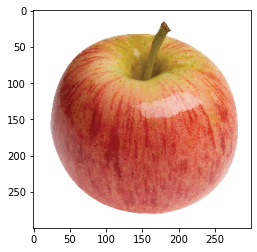

In [ ]:
plt.imshow(transforms(img).permute(1, 2, 0))